# Exercise 2 : Logistic Regresion 

## 1. Logistic Regresion 

### 1.1 Visualizing the Data

In [351]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

In [352]:
import pandas as pd 
df = pd.read_csv('../data/ex2data1.txt', sep=',', header=None)
df.columns = ['exam_score_1', 'exam_score_2', 'label']

In [353]:
df.head()

,exam_score_1,exam_score_2,label
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [354]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
exam_score_1,100.0,65.644274,19.458222,30.058822,50.919511,67.032988,80.212529,99.827858
exam_score_2,100.0,66.221998,18.582783,30.603263,48.179205,67.682381,79.360605,98.869436
label,100.0,0.600000,0.492366,0.000000,0.000000,1.000000,1.000000,1.000000


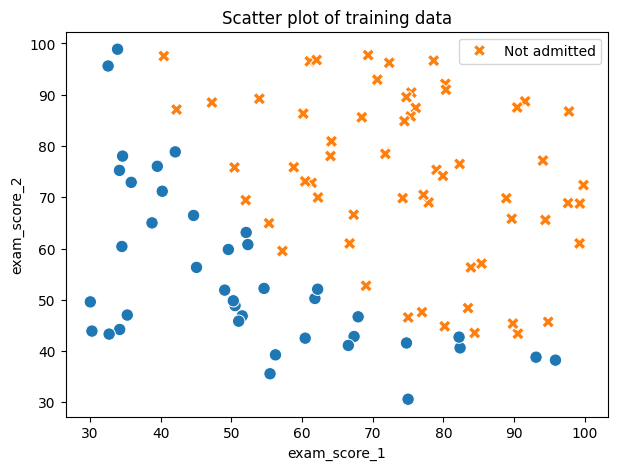

In [355]:
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x='exam_score_1', y='exam_score_2', hue='label', data=df, style='label', s=80)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ['Not admitted', 'Admitted'])
plt.title('Scatter plot of training data')
plt.show(ax)

### 1.2 Implementation
#### 1.2.1 Sigmoid FUnction 

Logistic regression hypothesis:

$$ h_\theta (x) = g(\theta^T x)$$
$$ g(z) = \frac{1}{1 + e^{-z}} $$

In [356]:
import jax.numpy as jnp 
from jax import jit, value_and_grad, grad, vmap 

@jit
def sigmoid(z):
    z = jnp.array(z)
    return 1/(1+jnp.exp(-z))

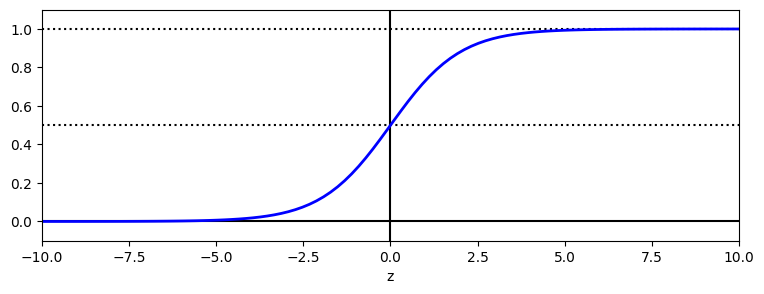

In [357]:

import matplotlib.pyplot as plt
%matplotlib inline
z = np.linspace(-10, 10, 100)
sig = sigmoid(z)
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(z, sig, "b-", linewidth=2)
plt.xlabel("z")
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

#### 1.2.2 Cost Function and Gradient 

Cost function in logistic regression is: 
$$J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} [y^i log(h_\theta (x^i)) + (1-y^i) log(1-h_\theta(x^i))] $$ 

Vectorized implementation: 
$$h = g(X\theta)$$
$$ J(\theta) = \frac{1}{m} (-y^T log(h) - (1-y)^Tlog(1-h))$$ 

In [358]:
@jit
def cost(theta,X,y):
    m = y.shape[0]
    h = sigmoid(X@theta)
    J = (1/m)* (-y.T@jnp.log(h) -(1-y).T@jnp.log(1-h))
    return J[0][0]

In [359]:
m = df.shape[0]
X = jnp.hstack((jnp.ones((m,1)),df[['exam_score_1', 'exam_score_2']].values))
y = jnp.array(df.label.values).reshape(-1,1)
theta = np.zeros(shape=(X.shape[1],1))
theta.shape, y.shape


((3, 1), (100, 1))

In [360]:
jit_value_grad = jit(value_and_grad(cost))

In [361]:
cost, grad_val = jit_value_grad(theta, X, y)
print('Cost at initial theta (zeros):', cost)
print('Expected cost (approx): 0.693')
print('Gradient at initial theta (zeros):')
print(grad_val.T)
print('Expected gradients (approx):\n -0.1000\n -12.0092\n -11.2628')

Cost at initial theta (zeros): 0.69314724
Expected cost (approx): 0.693
Gradient at initial theta (zeros):
[[ -0.10000001 -12.009216   -11.262841  ]]
Expected gradients (approx):
 -0.1000
 -12.0092
 -11.2628


In [362]:
test_theta = jnp.array([-24, 0.2, 0.2]).reshape(-1,1)
[cost, grad_val] = jit_value_grad(test_theta, X, y)

print('Cost at test theta:', cost)
print('Expected cost (approx): 0.218')
print('Gradient at test theta:')
print(grad_val.T)
print('Expected gradients (approx):\n 0.043\n 2.566\n 2.647')

Cost at test theta: 0.21833022
Expected cost (approx): 0.218
Gradient at test theta:
[[0.04290302 2.5662348  2.6467988 ]]
Expected gradients (approx):
 0.043
 2.566
 2.647


In [363]:
# minimize the cost function 
import optax 

lr = 0.07
optimizer = optax.adam(lr)
opt_state = optimizer.init(theta)

cost_history: list[float] = []
%time
for num_iter in range(4500):
    cost, grads = jit_value_grad(theta, X,y)
    updates, opt_state = optimizer.update(grads, opt_state)
    theta = optax.apply_updates(theta,updates)
    
    cost_history.append(cost)
    



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


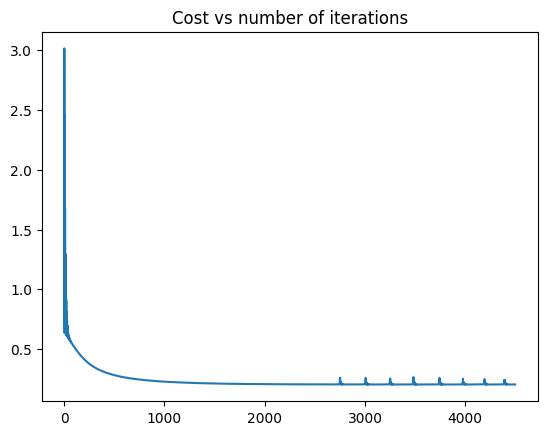

In [364]:
plt.plot(cost_history)
plt.title("Cost vs number of iterations")
plt.show()

In [365]:
theta

Array([[-25.21205   ],
       [  0.20666042],
       [  0.20190473]], dtype=float32)

In [366]:

print('Cost at theta found by fminunc:', cost)
print('Expected cost (approx): 0.203')
print('theta:\n', theta.reshape(-1,1))
print('Expected theta (approx):')
print(' -25.161\n 0.206\n 0.201')

Cost at theta found by fminunc: 0.20349815
Expected cost (approx): 0.203
theta:
 [[-25.21205   ]
 [  0.20666042]
 [  0.20190473]]
Expected theta (approx):
 -25.161
 0.206
 0.201


#### 1.2.3 Learning Parameters using an optimization solver 


In [367]:
def sigmoid2(z):
    z = np.array(z)
    return 1 / (1+np.exp(-z))

In [368]:
def cost_function(theta, X, y):
    m = y.shape[0]
    theta = theta[:, np.newaxis] #trick to make numpy minimize work
    h = sigmoid2(X.dot(theta))
    J = (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h)))

    diff_hy = h - y
    grad = (1/m) * diff_hy.T.dot(X)

    return J, grad

In [369]:
m = df.shape[0]
X = np.hstack((np.ones((m,1)),df[['exam_score_1', 'exam_score_2']].values))
y = np.array(df.label.values).reshape(-1,1)
initial_theta = np.zeros(shape=(X.shape[1]))

In [370]:
import scipy.optimize as opt
def optimize_theta(X, y, initial_theta):
    opt_results = opt.minimize(cost_function, initial_theta, args=(X, y), method='TNC',
                               jac=True, options={'maxiter':400})
    return opt_results['x'], opt_results['fun']

In [371]:
%time
opt_theta, cost = optimize_theta(X, y, initial_theta)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/tmp/ipykernel_6026/1274892550.py:3: OptimizeWarning: Unknown solver options: maxiter
  opt_results = opt.minimize(cost_function, initial_theta, args=(X, y), method='TNC',


In [372]:
cost2, grad2 = cost_function(opt_theta, X, y)
print('Cost at theta found by fminunc:', cost2)
print('Expected cost (approx): 0.203')
print('theta:\n', opt_theta.reshape(-1,1))
print('Expected theta (approx):')
print(' -25.161\n 0.206\n 0.201')

Cost at theta found by fminunc: [[0.2034977]]
Expected cost (approx): 0.203
theta:
 [[-25.16131857]
 [  0.20623159]
 [  0.20147149]]
Expected theta (approx):
 -25.161
 0.206
 0.201


### Decision boundary

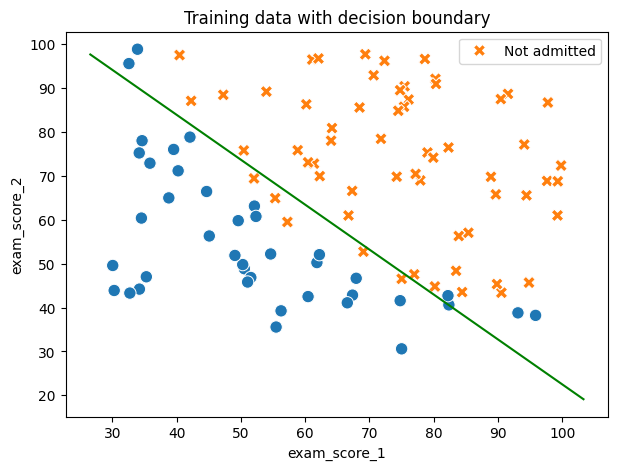

In [373]:

plt.figure(figsize=(7,5))
ax = sns.scatterplot(x='exam_score_1', y='exam_score_2', hue='label', data=df, style='label', s=80)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ['Not admitted', 'Admitted'])
plt.title('Training data with decision boundary')

plot_x = np.array(ax.get_xlim())
plot_y = (-1/theta[2]*(theta[1]*plot_x + theta[0]))
plt.plot(plot_x, plot_y, '-', c="green")
plt.show(ax)

#### 1.2.4 Evaluating Logistic Regression 
Predict whether a particular student will be 

In [374]:
prob = sigmoid(jnp.array([1, 45, 85]).dot(theta))
print('For a student with scores 45 and 85, we predict an admission probability of', prob)
print('Expected value: 0.775 +/- 0.002');

For a student with scores 45 and 85, we predict an admission probability of [0.7772256]
Expected value: 0.775 +/- 0.002


In [375]:
# Accuracy on training set 
def predict(X,theta):
    y_pred = [1 if sigmoid(X[i,:]@theta) >= 0.5 else 0 for i in range(0, X.shape[0])]
    return y_pred

In [376]:
X = jnp.hstack((jnp.ones((m,1)), df[['exam_score_1', 'exam_score_2']].values))
y_pred_prob = predict(X, theta)
f'Train accuracy: {np.mean(y_pred_prob == df.label.values) * 100}'

'Train accuracy: 89.0'

#### 1.2.5 Equivalent code using Scikit-learn: 

In [377]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='newton-cg', max_iter=400) 
log_reg.fit(df[['exam_score_1','exam_score_2']].values, df.label.values)

LogisticRegression(max_iter=400, solver='newton-cg')

In [378]:
log_reg.intercept_, log_reg.coef_

(array([-25.04072353]), array([[0.2052627, 0.2004914]]))

In [379]:
log_reg.score(df[['exam_score_1', 'exam_score_2']].values,
              df.label.values)

0.89

## Regularized Logistic Regression
In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assur- ance (QA).

### 2.1 Visualizing the Data

In [380]:
df2 = pd.read_csv('../data/ex2data2.txt', sep=',', header=None)
df2.columns = ['test_1', 'test_2', 'label']

In [381]:
df2.head()

,test_1,test_2,label
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [382]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
test_1,118.0,0.054779,0.496654,-0.83007,-0.372120,-0.006336,0.478970,1.0709
test_2,118.0,0.183102,0.519743,-0.76974,-0.254385,0.213455,0.646563,1.1089
label,118.0,0.491525,0.502060,0.00000,0.000000,0.000000,1.000000,1.0000


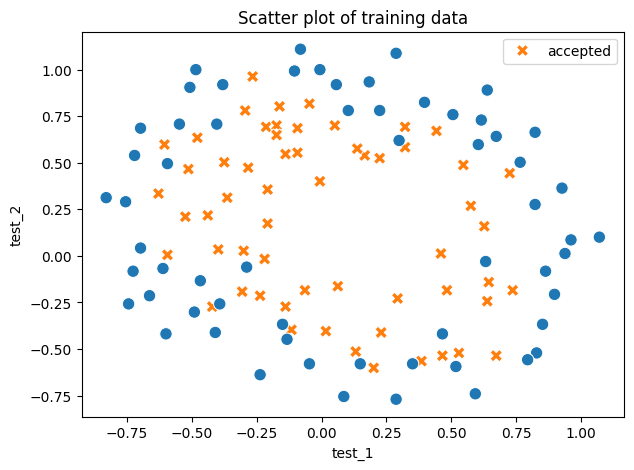

In [383]:
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x='test_1', y='test_2', hue='label', data=df2, style='label', s=80)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ['accepted', 'rejected'])
plt.title('Scatter plot of training data')
plt.show(ax)

### 2.2 Feature Mapping

One way to fit the data better is to create more features from each data point. We will map the features into all polynomial terms of x1 and  x2 up to the sixth power. As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

In [384]:
def map_feature(X1, X2, degree):
    X1 = np.array(X1).reshape(-1,1)
    X2 = np.array(X2).reshape(-1,1)
    
    out = np.ones((X1.shape[0],1))
    for i in range(1, degree+1):
        for j in range(0,i+1):
            p = (X1**(i-j)) * (X2**j)
            out = np.append(out, p, axis=1)
    return out 
    

In [385]:
X_p = map_feature(df2.test_1.values, df2.test_2.values, 6)
X_p.shape,

((118, 28),)

### 2.3 Cost Function and Gradient 
$$J(\theta) = -\frac{1}{m}\sum_{i=1}^m[y^i log(h_\theta(x^i))+(1-y^i)log(1-h_\theta(x^i))] + \frac{\lambda}{2m} \sum_{j=1}^n\theta_j^2$$


In [386]:
@jit
def cost_regu(theta, X, y, lambda_regu):
    m = y.shape[0]
    h = sigmoid(X@theta)
    J = (1/m) * (-y.T@jnp.log(h) - (1-y).T@jnp.log(1-h)) + (lambda_regu/(2*m)) * jnp.sum(theta[1:]**2)
    return J[0][0]

In [387]:
m = df.shape[0]
X = jnp.asarray(X_p)
y = jnp.array(df2.label.values).reshape(-1,1)
theta = np.zeros(shape=(X.shape[1],1))

jit_val_grad_regu = jit(value_and_grad(cost_regu))
theta.shape

(28, 1)

In [388]:
lr = 0.01 
optimizer = optax.adam(lr)
opt_state = optimizer.init(theta)
lambda_reg = 1
cost_history: list[float] = []

for num_iter in range(10000):
    cost3, grads3 = jit_val_grad_regu(theta,X,y, lambda_reg)
    updates, opt_state = optimizer.update(grads3, opt_state)
    theta = optax.apply_updates(theta, updates)
    
    cost_history.append(cost3) 
    # if cost3<0:
    #     break

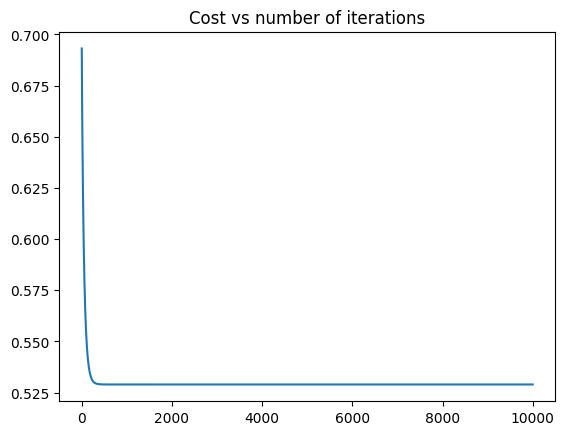

In [389]:
plt.plot(cost_history)
plt.title("Cost vs number of iterations")
plt.show()

In [390]:
def optimize_theta(theta,X,y,lambda_reg, itera):
    lr = 0.01 
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(theta)

    for num_iter in range(itera):
        cost3, grads3 = jit_val_grad_regu(theta,X,y, lambda_reg)
        updates, opt_state = optimizer.update(grads3, opt_state)
        theta = optax.apply_updates(theta, updates)
        # cost_history.append(cost3) 
    
    return theta, cost3 

In [391]:
initial_theta = np.zeros(shape=(X.shape[1],1))
cost3, grad3 = jit_val_grad_regu(initial_theta, X, y, lambda_reg)
print('Cost at initial theta (zeros):', cost3)
print('Expected cost (approx): 0.693')
print('Gradient at initial theta (zeros) - top 5:')
print(grad3[:5])
print('Expected gradients top 5(approx):\n 0.0085\n 0.0188\n 0.0001\n 0.0503\n 0.0115')

Cost at initial theta (zeros): 0.6931472
Expected cost (approx): 0.693
Gradient at initial theta (zeros) - top 5:
[[8.4745754e-03]
 [1.8788086e-02]
 [7.7774494e-05]
 [5.0344646e-02]
 [1.1501332e-02]]
Expected gradients top 5(approx):
 0.0085
 0.0188
 0.0001
 0.0503
 0.0115


In [392]:
lambda_reg = 10
initial_theta = np.zeros(shape=(X.shape[1],1))
cost3, grad3 = jit_val_grad_regu(initial_theta, X, y, lambda_reg)
print('Cost at initial theta:', cost3)
print('Expected cost (approx): 3.16')
print('Gradient at theta - top 5:')
print(grad3[:5])
print('Expected gradients top 5(approx):\n 0.3460\n 0.1614\n 0.1948\n 0.2269\n 0.0922')

Cost at initial theta: 0.6931472
Expected cost (approx): 3.16
Gradient at theta - top 5:
[[8.4745754e-03]
 [1.8788086e-02]
 [7.7774494e-05]
 [5.0344646e-02]
 [1.1501332e-02]]
Expected gradients top 5(approx):
 0.3460
 0.1614
 0.1948
 0.2269
 0.0922


/tmp/ipykernel_6026/2753900859.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = map_feature(u[i], v[j], 6).dot(theta_opt)
/tmp/ipykernel_6026/2753900859.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = map_feature(u[i], v[j], 6).dot(theta_opt)
/tmp/ipykernel_6026/2753900859.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = map_feature(u[i], v[j], 6).dot(theta_opt)
/tmp/ipykernel_6026/2753900859.py:11: DeprecationWarning: Conver

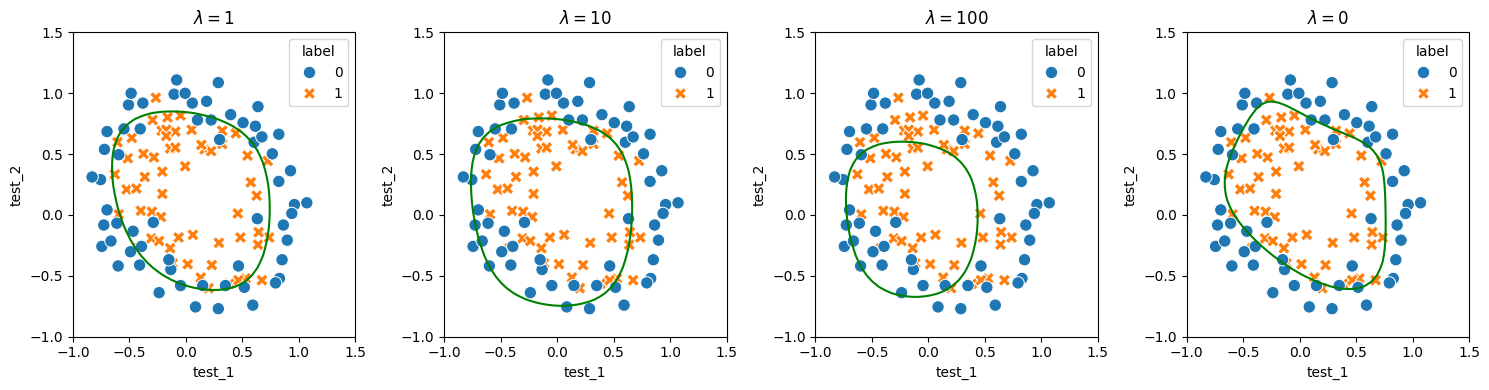

In [395]:
lambda_reg = [1, 10, 100, 0]
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)

for il, l in enumerate(lambda_reg):
    theta_opt, cost = optimize_theta(initial_theta, X, y, l, 2000)
    z = np.zeros((u.shape[0], v.shape[0]))
    for i in range(len(u)):
        for j in range(len(v)):
            z[i,j] = map_feature(u[i], v[j], 6).dot(theta_opt)
    
    sns.scatterplot(x='test_1', y='test_2', hue='label', data=df2, style='label', s=80, ax=axs[il])
    
    axs[il].contour(u, v, z.T, levels=[0], colors='green')
    axs[il].set_title('$\lambda={}$'.format(l))
fig.tight_layout()
plt.show()

### 2.5 Accuracy on Training set

In [398]:
lambda_reg = 1
theta, cost = optimize_theta(initial_theta,X,y, lambda_reg, 2000)
theta.T

Array([[ 1.2727387 ,  0.6252717 ,  1.1810882 , -2.0199566 , -0.9174234 ,
        -1.431664  ,  0.12400623, -0.36553434, -0.3572399 , -0.17513038,
        -1.4581587 , -0.05098896, -0.6155555 , -0.27470616, -1.1928155 ,
        -0.24218813, -0.20600615, -0.04473082, -0.27778462, -0.2953782 ,
        -0.4563577 , -1.0432042 ,  0.02777175, -0.29243147,  0.01556684,
        -0.3273798 , -0.14388701, -0.9246525 ]], dtype=float32)

In [399]:
y_pred_prob = predict(X, theta)
f'Train accuracy: {np.mean(y_pred_prob == df2.label.values) * 100}'

'Train accuracy: 83.05084745762711'

### 2.6 Equivalent code using Scikit-Learn:

In [400]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='newton-cg', max_iter=400)
log_reg.fit(X[:,1:], df2.label.values)

LogisticRegression(max_iter=400, solver='newton-cg')

In [401]:

log_reg.intercept_, log_reg.coef_

(array([1.2735244], dtype=float32),
 array([[ 0.62398666,  1.1777095 , -2.0189567 , -0.90970516, -1.4293263 ,
          0.12855265, -0.37114555, -0.36355376, -0.16833541, -1.4615067 ,
         -0.0542993 , -0.6210731 , -0.27327165, -1.1943754 , -0.23868643,
         -0.21008295, -0.04925362, -0.27848613, -0.29823303, -0.45449582,
         -1.0461488 ,  0.02489356, -0.29556254,  0.01337146, -0.32959205,
         -0.14390992, -0.928583  ]], dtype=float32))

In [402]:

log_reg.score(X[:,1:], df2.label.values)

0.8305084745762712